# Linear Regression (follow same build style as Logistic notebook)
This notebook reuses `get_clean_X_y()` from `data_utils` to load preprocessed data, performs nested stratified CV for unbiased evaluation while tuning regression-type models (LinearRegression, Ridge, Lasso, ElasticNet). Since the target is binary (0/1), predictions are thresholded at 0.5 for classification metrics in addition to regression metrics.

In [1]:
# Imports
import pandas as pd
import numpy as np
# Evaluation methods
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# Linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load cleaned data
from data_utils import get_clean_X_y
X, y = get_clean_X_y()

# Convert target to numeric: 'e' (edible) -> 0, 'p' (poisonous) -> 1
y = y.map({'e': 0, 'p': 1})

print('X shape:', X.shape)
print('y distribution:\n', y.value_counts())

X shape: (5644, 98)
y distribution:
 class
0    3488
1    2156
Name: count, dtype: int64


In [3]:
# Stratified train/test split (use same random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (4515, 98) Test shape: (1129, 98)


In [4]:
# Train a basic Linear Regression model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline with scaler and linear regression
lin_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
lin_reg.fit(X_train, y_train)

# Regression metrics on training set
y_train_pred = lin_reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training MSE: {train_mse:.6f}, R2: {train_r2:.6f}')

# Regression metrics on test set
y_test_pred_basic = lin_reg.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_basic)
test_r2 = r2_score(y_test, y_test_pred_basic)
print(f'Test MSE: {test_mse:.6f}, R2: {test_r2:.6f}')

Training MSE: 0.000000, R2: 1.000000
Test MSE: 0.000000, R2: 1.000000


### Nested Cross validation 
    Grid Search is great for cross validation but can potentially leak data between training and testing leading to an overfitting situation. You can combat this with nested Cross validation by appoximately maximizing score then directly maximizing via hyperparameter selection in the second loop

In [5]:
# Pipeline and parameter grid for LinearRegression only
# scaler is to "Standardize features [by] ... removing the mean and scaling to unit variance" -scikitlearn
# in other words standarization is ensuring each column/feature uses the same range. 
# scaler function is very sensitive to outliars
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

param_grid = [
    { 'model': [LinearRegression()], 'model__fit_intercept': [True, False] }
]

# Nested CV setup
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#n_jobs is to use all processors, verbose is how many messages are returned (amt of info)
grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

print(f"Running nested CV (outer={outer_cv.get_n_splits()}, inner={inner_cv.get_n_splits()}) — this may take a while...")
nested_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring='neg_mean_squared_error', n_jobs=-1)
# convert to positive MSE
nested_mse = -nested_scores
print('Nested CV MSE: mean={:.6f}, std={:.6f}'.format(nested_mse.mean(), nested_mse.std()))

# Refit on full data
print('Refitting GridSearchCV on full data...')
grid.fit(X, y)
print('Best params (full data):', grid.best_params_)
print('Best inner-CV score (neg MSE):', grid.best_score_)

best_reg = grid.best_estimator_
joblib.dump(best_reg, 'linear_best_model_nested.joblib')
print('Saved model to linear_best_model_nested.joblib')

Running nested CV (outer=5, inner=5) — this may take a while...
Nested CV MSE: mean=0.000000, std=0.000000
Refitting GridSearchCV on full data...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params (full data): {'model': LinearRegression(), 'model__fit_intercept': True}
Best inner-CV score (neg MSE): -3.1952180951341796e-30
Saved model to linear_best_model_nested.joblib


MSE: 0.000000, RMSE: 0.000000, R2: 1.000000
Classification accuracy (threshold=0.5): 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       431

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



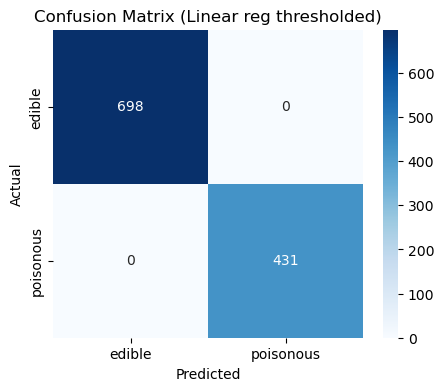

In [6]:
# Evaluate best regressor on held-out test set
y_pred_cont = best_reg.predict(X_test)
# Regression metrics
mse = mean_squared_error(y_test, y_pred_cont)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_cont)
# print to 6 decimal places
print(f'MSE: {mse:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}')

# Threshold predictions for classification evaluation
y_pred_class = (y_pred_cont >= 0.5).astype(int)
print('Classification accuracy (threshold=0.5):', accuracy_score(y_test, y_pred_class))
print('\nClassification report:\n', classification_report(y_test, y_pred_class))
# confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
# visialize matrix via heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['edible','poisonous'], yticklabels=['edible','poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear reg thresholded)')
plt.show()

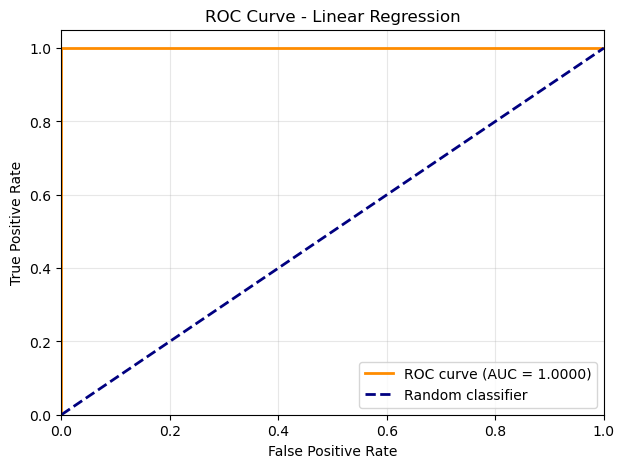

AUC Score: 1.0000


In [7]:
# ROC Curve visualization (using continuous predictions as probabilities)
from sklearn.metrics import roc_curve, roc_auc_score

# Use continuous predictions as "probabilities" for ROC curve
# Clip to [0,1] range since linear regression can predict outside this range
y_pred_proba = np.clip(y_pred_cont, 0, 1)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Linear Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f'AUC Score: {auc_score:.4f}')

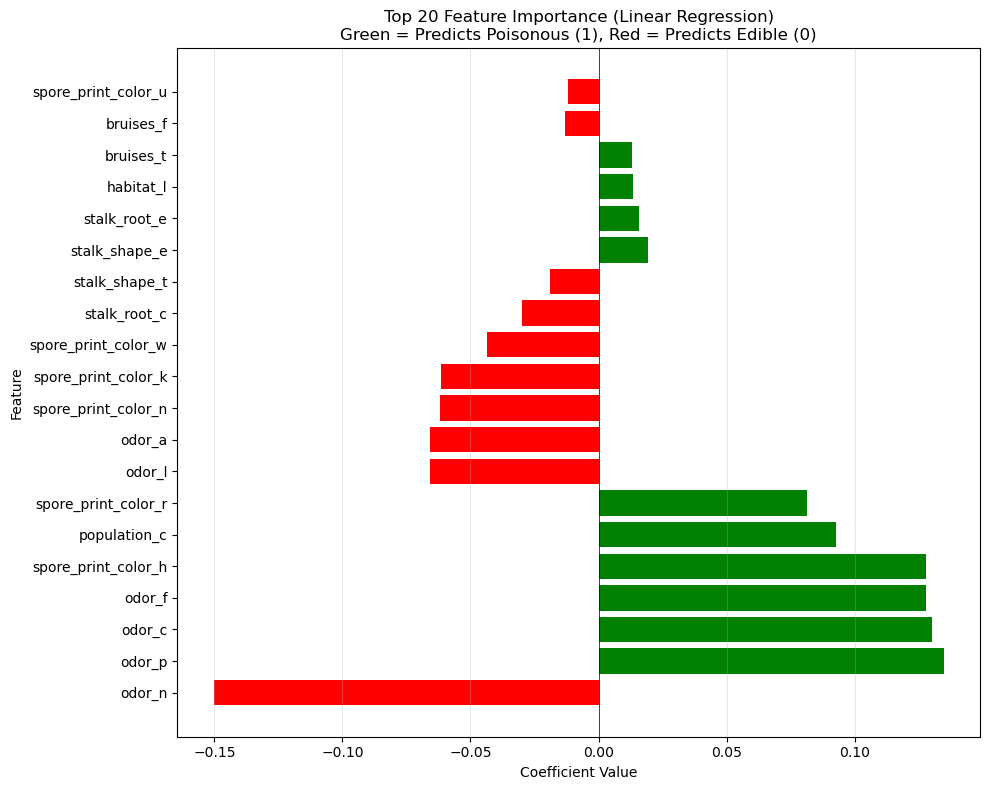


Total features: 98
Non-zero coefficients: 98


In [8]:
# Feature Importance (Coefficients) visualization
# Extract the LinearRegression model from the pipeline
linear_model = best_reg.named_steps['model']
coefficients = linear_model.coef_
feature_names = X.columns

# Create DataFrame for easier manipulation
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sort by absolute value and get top 20
top_features = coef_df.sort_values('abs_coefficient', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance (Linear Regression)\nGreen = Predicts Poisonous (1), Red = Predicts Edible (0)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nTotal features: {len(feature_names)}')
print(f'Non-zero coefficients: {np.sum(coefficients != 0)}')